Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [73]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [74]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [75]:
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
        
    print('Results of Dickey-Fuller Test:')
    
    if dftest[0]> dftest[4]['5%']: 
        print('Eсть единичные корни, ряд не стационарен')
    else:
        print('Eдиничных корней нет, ряд стационарен')
            
    print(dfoutput)

In [76]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [77]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [84]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [85]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [86]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [87]:
def plot_dema(series, alpha, beta):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='yellow', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

In [195]:
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")

In [196]:
airlines = airlines_passengers.set_index(pd.DatetimeIndex(airlines_passengers['Month']))

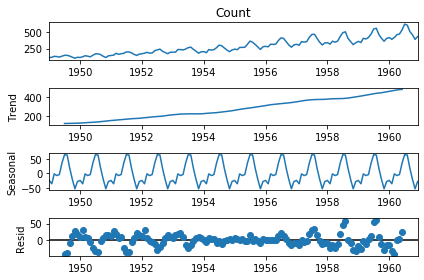

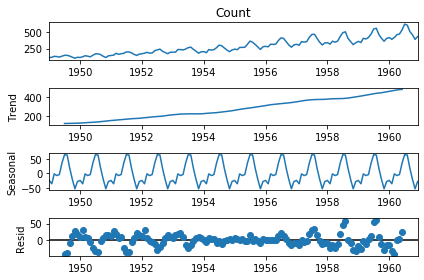

In [197]:
# Посмотреть из чего складывается наш ряд "robberies_in_boston". 
res = sm.tsa.seasonal_decompose(airlines['Count'])
res.plot()

In [198]:
series = {"International airline passengers: monthly totals in thousands": airlines_passengers["Count"]}

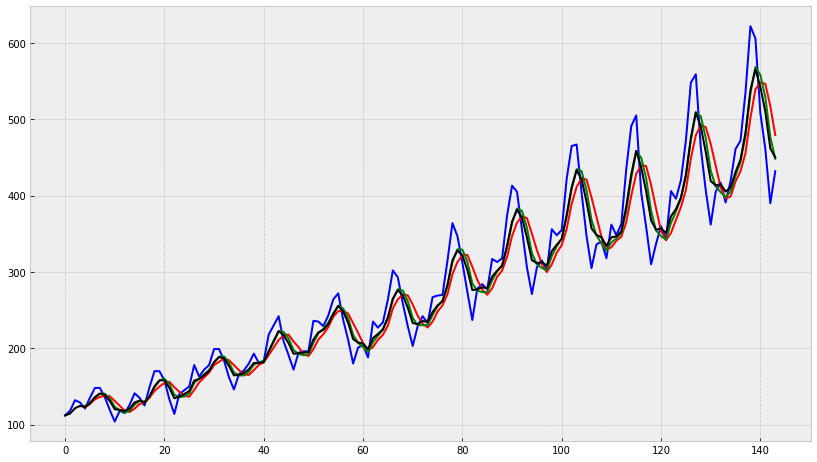

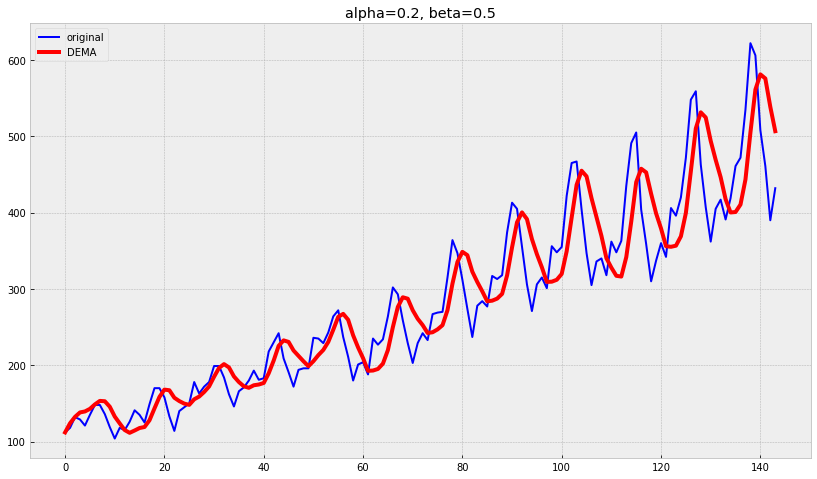

In [199]:
ema = exponential_moving_average(airlines_passengers["Count"], 0.4)
wma = weighted_moving_average(airlines_passengers["Count"], 5, [2,4,6,8,10])
ma = moving_average(airlines_passengers["Count"], 5)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airlines_passengers["Count"], color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plot_dema(airlines_passengers["Count"], 0.2, 0.5)
    plt.legend()

In [200]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [201]:
series = airlines_passengers["Count"]

In [202]:
train, test, val = series[:60], series[60:70], series[70:]

In [203]:
def mse(X):
    alpha, beta = X
    result = double_ema(train, alpha, beta)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [204]:
opt = minimize(mse, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [205]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 202.81523570945495
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.99174052e-04, -9.60693797e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 81
      nit: 9
   status: 0
  success: True
        x: array([0.15068528, 1.        ])


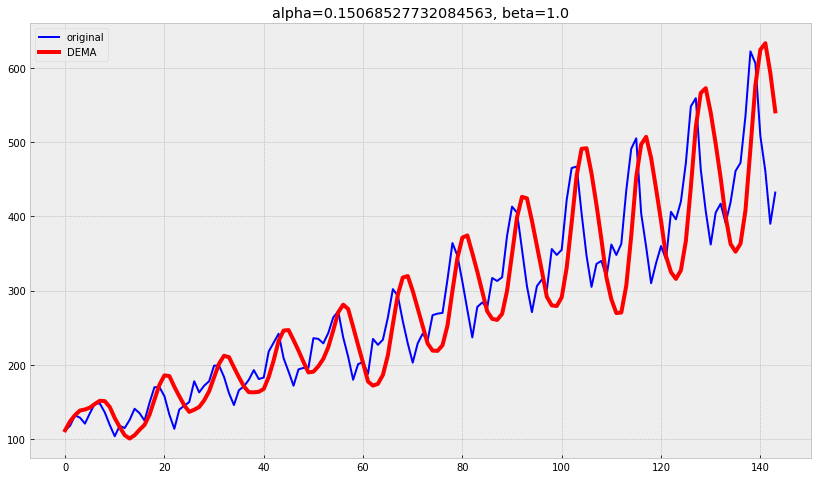

In [206]:
plot_dema(series, alpha_opt, beta_opt)

In [207]:
train, val = series[:65], series[65:]

In [208]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]

        result = double_ema(train, alpha, beta)
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)

    return np.mean(np.array(errors))

In [209]:
opt = minimize(mse_cross_val, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [210]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 2661.1361634242453
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00363798, -0.00491127])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 81
      nit: 18
   status: 0
  success: True
        x: array([0.25625734, 0.0765846 ])


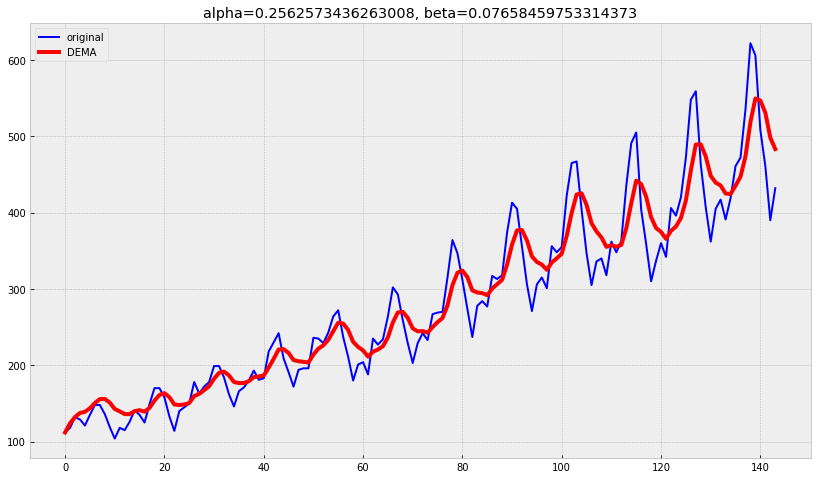

In [211]:
plot_dema(series, alpha_opt, beta_opt)

Results of Dickey-Fuller Test:
Eдиничных корней нет, ряд стационарен
Test Statistic                -1.559562e+01
p-value                        1.856512e-28
#Lags Used                     0.000000e+00
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64


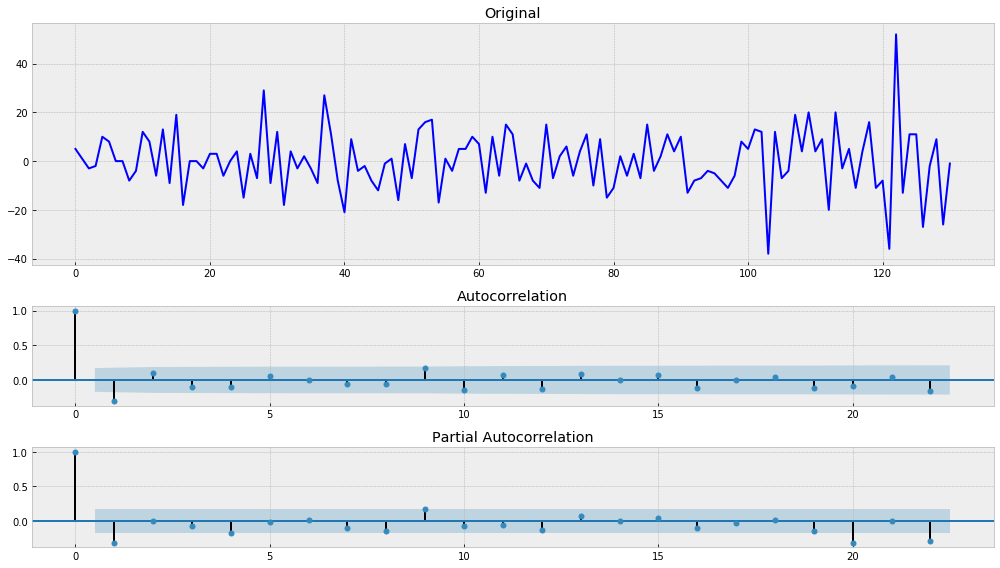

In [212]:
#Сделаем ряд стационарным
series = difference(airlines_passengers["Count"])
series = difference(series, 12)
tsplot(series)

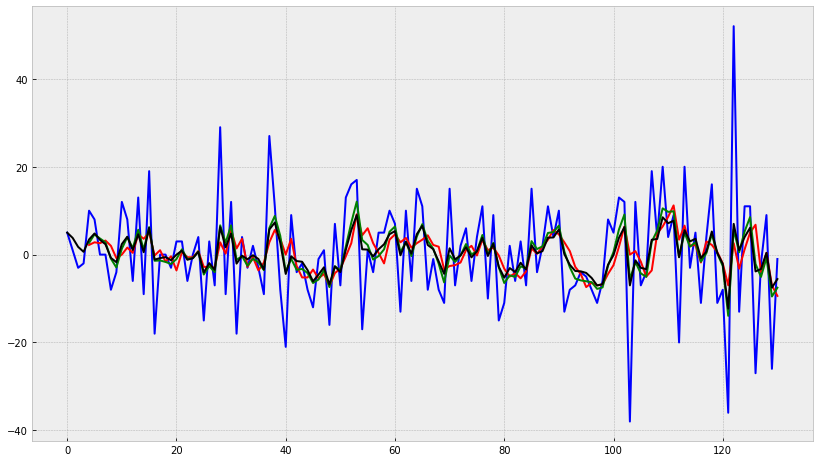

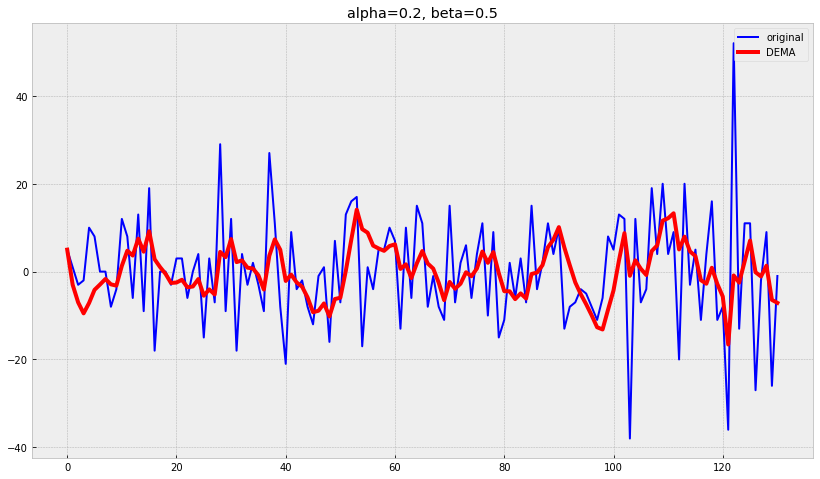

In [213]:
ema = exponential_moving_average(series, 0.3)
wma = weighted_moving_average(series, 5, [2,4,6,8,10])
ma = moving_average(series, 5)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plot_dema(series, 0.2, 0.5)
    plt.legend()